In [14]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from keras import optimizers
from keras import backend as K
import glob
import glob
import os

from PIL import Image

import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [15]:
#https://github.com/Yunski/nvidia-cnn

def steer_converter(num,typ,to=1,fro=-1,length_out=255):

    d = (to-fro)/(length_out-1)
    
    if typ == "reduce":
        
        res = np.round(num*d,1)
        
        if res < -1 or res > 1:
            
            res = np.round(res)

        return res
    
    elif typ == "expand":
        
        res = num/d
        
        return res

In [20]:
# Global variable
OUT_SHAPE = 1
INPUT_SHAPE = (66, 200, 3)
input_width = 200
input_height = 66
input_channels = 3

def customized_loss(y_true, y_pred, loss='euclidean'):
    # Simply a mean squared error that penalizes large joystick summed values
    if loss == 'L2':
        L2_norm_cost = 0.001
        val = K.mean(K.square((y_pred - y_true)), axis=-1) \
                    + K.sum(K.square(y_pred), axis=-1)/2 * L2_norm_cost
    # euclidean distance loss
    elif loss == 'euclidean':
        val = K.sqrt(K.sum(K.square(y_pred-y_true), axis=-1))
    return val

In [21]:
def create_model(keep_prob = 0.8):
    model = Sequential()

    # NVIDIA's model
    model.add(Conv2D(24, kernel_size=(5, 5), strides=(2, 2), activation='relu', input_shape= INPUT_SHAPE))
    model.add(Conv2D(36, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(48, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(1164, activation='relu'))
    drop_out = 1 - keep_prob
    model.add(Dropout(drop_out))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(OUT_SHAPE, activation='softsign'))

    return model

In [55]:
def load_training_data():

    X, y = [], []
    X_train, y_train = [], []
    X_val, y_val = [], []

    recordings = glob.iglob("cap/*")
    
    for R in recordings:
    
        filenames = list(glob.iglob('{}/*.png'.format(R)))
        steering = [float(line) for line in open(("{}/steering.txt").format(R)).read().splitlines()]
        assert len(filenames) == len(steering), \
        "For recording {}, num steer values does not match num images.".format(R)

        for file, steer in zip(filenames, steering):
        
            assert steer >= -128 and steer <= 127
            
            steeR = steer_converter(steer,"reduce")
        
            # split to valid

            im = Image.open(file).resize((input_width, input_height))
            im_arr = np.frombuffer(im.tobytes(), dtype=np.uint8)
            im_arr = im_arr.reshape((input_height, input_width, input_channels))
            
            X.append(im_arr)
            y.append(steeR)
            
    i_X = round(len(X)*.8)
    i_y = round(len(y)*.8)
    
    X_train = X[:i_X]
    X_val = X[i_X:]
    y_train = y[:i_y]
    y_val = y[i_y:]
    
    # convert training vals

    assert len(X_train) == len(y_train)
    assert len(X_val) == len(y_val)

    return np.asarray(X_train), \
    np.asarray(y_train).reshape((len(y_train), 1)), \
    np.asarray(X_val), \
    np.asarray(y_val).reshape((len(y_val), 1))

In [56]:
X_train, y_train, X_val, y_val = load_training_data()
print(X_train.shape[0], 'training samples.')
print(X_val.shape[0], 'validation samples.')

4292 training samples.
1073 validation samples.


In [91]:
# Training loop variables
epochs = 10
batch_size = 50
model = create_model()
model.compile(loss=customized_loss, optimizer=optimizers.adam())

checkpointer = ModelCheckpoint(monitor='val_loss',
                               filepath='weights_dir/model_weights.h5',
                               verbose=1,
                               save_best_only=True,
                               mode='min')

earlystopping = EarlyStopping(monitor='val_loss', patience=20)

model.fit(
X_train, 
y_train, 
batch_size=batch_size, 
epochs=epochs,
shuffle=True, 
validation_data=(X_val, y_val), 
callbacks=[checkpointer, earlystopping],
verbose=1
)

model.save_weights('weights_dir/model_weights.h5')

Train on 4292 samples, validate on 1073 samples
Epoch 1/10
4292/4292 [==============================] - 72s 17ms/step - loss: 0.3234 - val_loss: 0.1838

Epoch 00001: val_loss improved from inf to 0.18378, saving model to weights_dir/model_weights.h5
Epoch 2/10
4292/4292 [==============================] - 56s 13ms/step - loss: 0.1833 - val_loss: 0.1838

Epoch 00002: val_loss did not improve from 0.18378
Epoch 3/10
4292/4292 [==============================] - 56s 13ms/step - loss: 0.1834 - val_loss: 0.1838

Epoch 00003: val_loss did not improve from 0.18378
Epoch 4/10
4292/4292 [==============================] - 62s 14ms/step - loss: 0.1834 - val_loss: 0.1838

Epoch 00004: val_loss did not improve from 0.18378
Epoch 5/10
4292/4292 [==============================] - 66s 15ms/step - loss: 0.1833 - val_loss: 0.1839

Epoch 00005: val_loss did not improve from 0.18378
Epoch 6/10
4292/4292 [==============================] - 66s 15ms/step - loss: 0.1834 - val_loss: 0.1840

Epoch 00006: val_loss

In [92]:
model = create_model()

model.load_weights("weights_dir/model_weights.h5")

In [93]:
def prepare_image(im):
    im = im.resize((input_width, input_height))
    im_arr = np.frombuffer(im.tobytes(), dtype=np.uint8)
    im_arr = im_arr.reshape((input_height, input_width, input_channels))
    im_arr = np.expand_dims(im_arr, axis=0)
    return im_arr

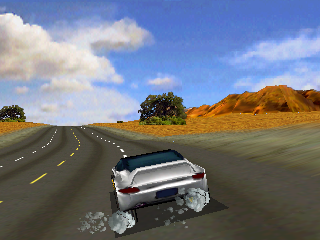

In [96]:
i = 77
im = load_img("cap/run_12/"+str(i)+".png")
prediction = model.predict(prepare_image(im), batch_size=1)[0]
im

In [97]:
print(prediction)

[0.00010418]
